In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

import jax.numpy as jnp
from jax.experimental.ode import odeint
from jax import vmap, jit, jacfwd, jacrev
from jax.nn import softplus, relu

np.random.seed(123)

Let $x(t)$ represent a vector of $n_x$ time dependent variables. We'll use an ordinary differential equation (ODE) model to characterize the rate of change of the variables, 

$$
\frac{d x(t)}{d t} = f(x(t), w)
$$
where $w$ is a vector of $n_w$ learnable parameters. 

Model estimates of $x(t)$ are computed by integrating the ODE, 

$$
y(t, x_0, w) = x_0 + \int_0^t f(x(t), w) d t 
$$

Model estimates of $x(t)$ are denoted as $y(t, x_0, w)$ and measuremed values are denoted as $y(t)$. 

Ground truth ODE model

In [2]:
# growth rate
r = .75

# carrying capacity
k = .75
    
def dxdt(x, t):
    
    # rate of change
    dxdt = x * r * (1. - x/k)
    
    return dxdt 

In [3]:
# initial condition
x0 = .1

# time frame 
t_span = np.linspace(0, 10, 50)

# simulate data
y_mean = odeint(dxdt, x0, t_span)

# sparsely sampled 
t_sparse = np.linspace(0, 10, 5)
y_sparse = odeint(dxdt, x0, t_sparse)

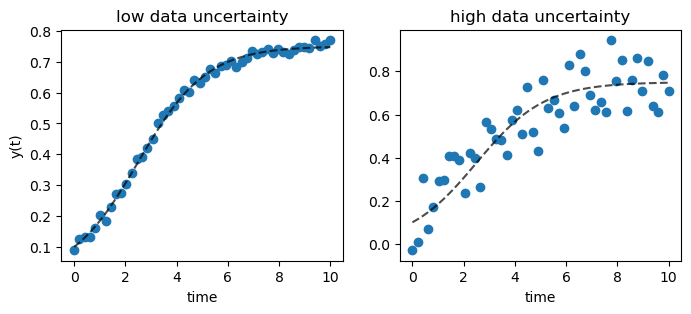

In [4]:
# plot data
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.plot(t_span, y_mean, linestyle='--', c='k', alpha=.7)
plt.scatter(t_span, y_mean + .01 * np.random.randn(len(y_mean)))
plt.title('low data uncertainty')
plt.xlabel("time")
plt.ylabel('y(t)')

plt.subplot(1, 2, 2)
plt.plot(t_span, y_mean, linestyle='--', c='k', alpha=.7)
plt.scatter(t_span, y_mean + .1 * np.random.randn(len(y_mean)))
plt.title('high data uncertainty')
plt.xlabel("time")
plt.show()

The distribution of the data conditioned on the input is important to characterize correctly and is used to define the likelihood function. 

In this case, the data distribution is Gaussian with mean $y(x_0, t, w)$ and variance $\beta^2$.  

$$
p(y(t) | x_0, t, w, \beta) = \mathcal{N}(y(t) | y(x_0, t, w), \beta^2)
$$

Variational Inference 

Goal of variational inference is to minimize the Kullback-Leibler divergence between an approximate posterior distribution and the true parameter posterior distribution. 

The true parameter distribution is given by Bayes' theorem as proportional to the product of the likelihood and the prior on parameters. 

With a data set denoted as $D = \{y(t_1), ..., y(t_N)\}$, the likelihood captures data uncertainty,

$$
p(D | w, \beta) = \prod_{i=1}^N \mathcal{N}(y(t_i) | y(x_0, t_i, w), \beta^2)
$$

A zero-mean Gaussian prior distribution promotes simplicity in the model, 

$$
p(w_j) = \mathcal{N}(w_j | 0, \alpha_j) 
$$

The postrior distribution is 

$$
p(w | D, \alpha, \beta) = \frac{p(D | w, \beta) p(w)}{p(D|\alpha, \beta)}
$$

$$
p(w | D, \alpha, \beta) = \frac{\prod_{i=1}^N \mathcal{N}(y(t_i) | y(x_0, t_i, w), \beta^2) \prod_{j=1}^{n_w} \mathcal{N}(w_j | 0, \alpha_j)}{p(D|\alpha, \beta)}
$$

The goal of variational inference is to approximate this distribution using a parametric distribution, $q(w | \theta)$. Optimization of $\theta$ is performed by minimizing the Kullback-Leibler divergence with the true posterior, 

$$
\theta^* = \text{arg} \; \underset{\theta}{\text{min}} \; 
\text{KL} \left[ q(w | \theta) || p(w | D, \alpha, \beta) \right]
$$

where 

$$
\text{KL} \left[ q(w | \theta) || p(w | D, \alpha, \beta) \right] = 
-\int_w q(w | \theta) \mathrm{ln} \frac{p(w | D, \alpha, \beta)}{q(w | \theta)} d w
$$

$$
= -\int_w q(w | \theta) \mathrm{ln} p(w | D, \alpha, \beta) d w + \int_w q(w | \theta) \mathrm{ln} q(w | \theta) d w
$$

To enable a flexible class of approximating distributions, we'll use the change of variables formula to transform samples from a distribution that's easy to sample from, 

$$
w = T(z, \theta), \quad z_j \sim \mathcal{N}(z_j | 0, 1) 
$$ 

The change of variables formula gives, 

$$
q(w | \theta) = p(z) \cdot | \mathrm{det} \nabla_{z} T(z, \theta) |^{-1}
$$

and 

$$
\mathrm{ln} q(w|\theta) = \mathrm{ln} p(z) - \mathrm{ln} | \mathrm{det} 
\nabla_{z} T(z, \theta)|
$$

We can use a Monte Carlo estimate of the $KL$ divergence, where each $z_i^k \sim \mathcal{N}(0, 1)$,

$$
\text{KL} \left[ q(w | \theta) || p(w | D, \alpha, \beta) \right] \approx
\frac{1}{K} \sum_{k=1}^K -\mathrm{ln} p(T(z^k, \theta) | D, \alpha, \beta) - \mathrm{ln} | \mathrm{det} 
\nabla_{z} T(z^k, \theta)|
$$

$$
=\frac{1}{K} \sum_{k=1}^K \left( \sum_{i=1}^N -\mathrm{ln} \mathcal{N}(y(t_i) | y(x_0, t_i, T(z^k, \theta)), \beta^2) - \sum_{j=1}^{n_w} \mathrm{ln}\mathcal{N}(T_j(z^k, \theta) | 0, \alpha_j) -\mathrm{ln} | \mathrm{det} 
\nabla_{z} T(z^k, \theta)| \right)
$$

Keeping only terms that depend on $\theta$, we'll define the objective function
$$
J(\theta) =\frac{1}{K} \sum_{k=1}^K \left( \sum_{i=1}^N \frac{(y(t_i) - y(x_0, t_i, T(z^k, \theta))^2}{2 \beta^2} + \sum_{j=1}^{n_w} \frac{T_j^2(z^k, \theta)}{2 \alpha_j^2} - \mathrm{ln} | \mathrm{det} 
\nabla_{z} T(z^k, \theta)| \right)
$$

In [5]:
# function to transform latent variables
def T(z, theta): 
    
    # unpack variational parameters 
    m, s = theta
    
    # independent Gaussian distribution 
    # w = softplus(m) + softplus(s) * z 
    w = m + jnp.exp(s) * z 
    
    return w 

# general function to compute log of absolute determinant 
def log_abs_det_T(z, theta):
    
    # Jacobian w.r.t. z 
    jac = jacfwd(T)(z, theta)
    
    # return log abs det 
    return jnp.log(jnp.abs(jnp.linalg.det(jac)))

# negative log likelihood component of KL divergence 
def neg_log_likelihood(y, x0, t, w, beta):
    
    # transform theta  
    # w = T(z, theta) 
    
    # model predictions 
    y_hat = model(x0, t, w)
    
    # return squared error 
    return (y - y_hat) ** 2 / beta ** 2 / 2.

# negative log of prior 
def neg_log_prior(w, alpha):
    
    # transform theta
    # w = T(z, theta)
    
    # return sum of squares
    return jnp.sum(w ** 2 / alpha ** 2) / 2. 

# overall per sample cost function 
@jit
def J(theta, z, y, x0, t, alpha, beta, M, N):
    
    # random sample
    w = T(z, theta)
    
    # negative log likelihood
    nll = neg_log_likelihood(y, x0, t, w, beta)
    
    # negative log prior
    nlp = neg_log_prior(w, alpha) / N 
    
    # posterior entropy
    lad = log_abs_det_T(w, theta) / N 
    
    return nll + nlp - lad 

# gradient of cost w.r.t. theta  
J_grad = jit(jacrev(J))

In [6]:
def adam(loss, grad, data, theta, params, n_sample=1, n_epochs=100, lr=1e-3, beta1=.9, beta2=.999, epsilon=1e-8):
    
    # unpack data set
    y, x0, t = data
    N = len(y)
    order = np.arange(N)
    
    # additional hyperparameters
    alpha, beta, M = params
    
    # init params 
    c = 0
    m = np.zeros_like(theta)
    v = np.zeros_like(theta)
    
    # loop over epochs
    for epoch in range(n_epochs):
    
        # sgd over each sample
        np.random.shuffle(order)
        epoch_loss = 0.
        for idx in order:
            
            # estimate gradient 
            gradient = 0.
            for _ in range(n_sample):
                
                # random sample
                z = np.random.randn(M)
                
                # evaluate gradient
                gradient += np.nan_to_num(grad(theta, 
                                               z, 
                                               y[idx], 
                                               x0[idx], 
                                               t[idx], 
                                               alpha, beta, M, N)) / n_sample
                
                # evaluate loss
                epoch_loss += np.nan_to_num(loss(theta, 
                                                 z, 
                                                 y[idx], 
                                                 x0[idx], 
                                                 t[idx], 
                                                 alpha, beta, M, N)) / n_sample

            # moment estimation
            c += 1   
            m = beta1 * m + (1 - beta1) * gradient
            v = beta2 * v + (1 - beta2) * (gradient ** 2)

            # adjust moments based on number of iterations
            m_hat = m / (1 - beta1 ** c)
            v_hat = v / (1 - beta2 ** c)

            # take step
            theta -= lr * m_hat / (np.sqrt(v_hat) + epsilon)
                
        print(f"Epoch {epoch+1:.0f}, Loss {epoch_loss:.5f}")
        
    # return params
    return theta 

Define model to fit

In [7]:
# rate of change of model
def dmdt(x, t, w):
    
    # unpack model parameters
    r, k = w
    
    # rate of change
    dxdt = x * r * (1. - x/k)
    
    return dxdt 

# model integrates ode up to time t 
def model(x0, t, w):
    
    # integrate dmdt from x0 to xt 
    return odeint(dmdt, x0, jnp.linspace(0, t), w)[-1]

# model integrates ode up to time t 
def model_tspan(x0, tspan, w):
    
    # integrate dmdt from x0 to xt 
    return odeint(dmdt, x0, tspan, w)

In [8]:
# params 
alpha = 10.
beta = .075
M = 2

# data set
x0 = .1
t = np.linspace(0., 10., 8)
y = odeint(dxdt, x0, t) + beta * np.append(0., np.random.randn(len(t)-1))
D = (y[1:], [x0]*len(y[1:]), t[1:])

# init params
mu = jnp.ones(M)
s = -jnp.ones(M)
theta = [mu, s]

In [9]:
theta = adam(J, J_grad, D, theta, (alpha, beta, M), 
             lr=1e-3, n_sample=5, n_epochs=1000)

Epoch 1, Loss 111.73054
Epoch 2, Loss 72.00734
Epoch 3, Loss 86.29343
Epoch 4, Loss 75.42559
Epoch 5, Loss 76.95038
Epoch 6, Loss 93.98374
Epoch 7, Loss 95.31931
Epoch 8, Loss 124.61042
Epoch 9, Loss 87.07592
Epoch 10, Loss 64.85162
Epoch 11, Loss 73.56795
Epoch 12, Loss 48.41338
Epoch 13, Loss 66.18439
Epoch 14, Loss 53.45033
Epoch 15, Loss 70.97459
Epoch 16, Loss 85.72505
Epoch 17, Loss 31.67963
Epoch 18, Loss 86.88988
Epoch 19, Loss 63.62181
Epoch 20, Loss 93.82009
Epoch 21, Loss 46.02704
Epoch 22, Loss 54.04608
Epoch 23, Loss 45.86288
Epoch 24, Loss 133.41435
Epoch 25, Loss 63.56769
Epoch 26, Loss 77.18426
Epoch 27, Loss 55.23642
Epoch 28, Loss 80.91684
Epoch 29, Loss 44.24411
Epoch 30, Loss 60.51891
Epoch 31, Loss 49.09843
Epoch 32, Loss 44.00258
Epoch 33, Loss 32.11621
Epoch 34, Loss 77.03177
Epoch 35, Loss 34.35390
Epoch 36, Loss 45.62989
Epoch 37, Loss 54.58613
Epoch 38, Loss 65.30353
Epoch 39, Loss 38.52749
Epoch 40, Loss 42.79001
Epoch 41, Loss 65.02503
Epoch 42, Loss 59.3508

Epoch 348, Loss 16.94800
Epoch 349, Loss 15.46346
Epoch 350, Loss 24.53398
Epoch 351, Loss 16.48388
Epoch 352, Loss 20.50445
Epoch 353, Loss 20.08589
Epoch 354, Loss 13.38394
Epoch 355, Loss 22.67468
Epoch 356, Loss 18.13115
Epoch 357, Loss 23.05482
Epoch 358, Loss 21.59691
Epoch 359, Loss 15.21395
Epoch 360, Loss 11.34050
Epoch 361, Loss 16.78875
Epoch 362, Loss 14.85994
Epoch 363, Loss 23.15347
Epoch 364, Loss 19.57958
Epoch 365, Loss 19.86898
Epoch 366, Loss 14.36877
Epoch 367, Loss 20.57661
Epoch 368, Loss 21.80359
Epoch 369, Loss 19.64001
Epoch 370, Loss 13.72406
Epoch 371, Loss 13.59750
Epoch 372, Loss 18.91258
Epoch 373, Loss 18.06583
Epoch 374, Loss 16.14439
Epoch 375, Loss 21.54462
Epoch 376, Loss 14.49757
Epoch 377, Loss 16.51436
Epoch 378, Loss 13.69060
Epoch 379, Loss 18.58403
Epoch 380, Loss 15.41967
Epoch 381, Loss 16.84535
Epoch 382, Loss 14.99565
Epoch 383, Loss 15.16264
Epoch 384, Loss 19.47881
Epoch 385, Loss 18.05047
Epoch 386, Loss 13.06442
Epoch 387, Loss 12.29353


Epoch 684, Loss 9.70224
Epoch 685, Loss 14.13350
Epoch 686, Loss 11.35209
Epoch 687, Loss 12.28061
Epoch 688, Loss 12.71803
Epoch 689, Loss 17.00550
Epoch 690, Loss 13.35573
Epoch 691, Loss 12.41342
Epoch 692, Loss 14.01384
Epoch 693, Loss 16.29352
Epoch 694, Loss 13.79525
Epoch 695, Loss 11.13503
Epoch 696, Loss 12.26638
Epoch 697, Loss 15.08677
Epoch 698, Loss 9.94551
Epoch 699, Loss 12.15744
Epoch 700, Loss 12.56093
Epoch 701, Loss 13.11879
Epoch 702, Loss 14.96014
Epoch 703, Loss 13.36321
Epoch 704, Loss 12.97300
Epoch 705, Loss 16.58091
Epoch 706, Loss 12.04977
Epoch 707, Loss 12.48023
Epoch 708, Loss 10.05560
Epoch 709, Loss 16.35193
Epoch 710, Loss 12.40003
Epoch 711, Loss 12.13983
Epoch 712, Loss 11.98803
Epoch 713, Loss 12.65254
Epoch 714, Loss 15.06395
Epoch 715, Loss 10.29220
Epoch 716, Loss 14.40085
Epoch 717, Loss 13.76503
Epoch 718, Loss 13.07434
Epoch 719, Loss 14.87781
Epoch 720, Loss 14.28522
Epoch 721, Loss 12.74882
Epoch 722, Loss 9.38849
Epoch 723, Loss 16.89474
Epo

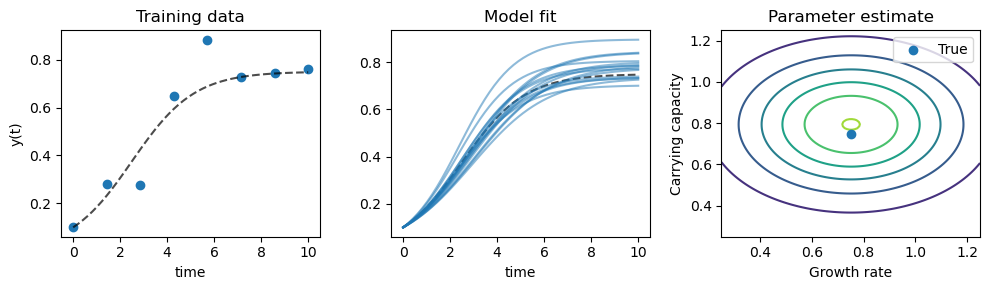

In [10]:
# plot data
plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
plt.plot(t_span, y_mean, linestyle='--', c='k', alpha=.7)
plt.scatter(t, y)
plt.title('Training data')
plt.xlabel("time")
plt.ylabel('y(t)')

plt.subplot(1, 3, 2)
plt.plot(t_span, y_mean, linestyle='--', c='k', alpha=.7)
for _ in range(15):
    
    # random sample
    z = np.random.randn(M)
    w = T(z, theta)
    
    # sim model 
    y_sim = model_tspan(x0, t_span, w)
    plt.plot(t_span, y_sim, c='C0', alpha=.5)
plt.title('Model fit')
plt.xlabel("time")

# plot params
plt.subplot(1, 3, 3)
xp, yp = np.linspace(r-.5, r+.5, 100), np.linspace(k-.5, k+.5, 100)
X, Y = np.meshgrid(xp, yp)
pos = np.dstack((X, Y))

# unpack params
m, s = theta
cov = np.diag(np.exp(s))
rv = multivariate_normal(m, cov)
Z = rv.pdf(pos)
plt.contour(X, Y, Z, levels=5, cmap='viridis', zorder=0)
plt.xlabel("Growth rate")
plt.ylabel("Carrying capacity")
plt.title("Parameter estimate")
plt.scatter([r],[k],label='True', zorder=1)
plt.legend()

plt.tight_layout()
plt.show()